**Question 1. For the beam shown in figure 1, determine the following. E = 210 GPa, I = 60 x
10-6 m-4, and P = 20 kN, L1=L2= 2m.**
1. Global stiffness matrix for the structure.
2. Vertical displacement at node 2.
3. Rotations at nodes 2 and 3.
4. Reactions at nodes 1 and 3.
5. Shear force and bending moment in each element.
6. SFD for each element.
7. BMD for each element.


In [2]:
#Defining Node and Beam
import numpy as np
import matplotlib.pyplot as plt

class Node:
    """Node(2D)
        -Num= node id
        -Pos: Coordinate Position
        -Disp: [u1,u2], =[None,None] if unknown (#Generalized disp, for beam u1 is vertical disp and u2 is rotation)
        -Restrained[i]==1 if restrained 0 if unrestrained
        -Load Vector=[P1,P2]        (#Generalized Load, for beam P1 is vertical force and P2 is counterclockwise moment)
        -Association[i]=Structure DOF corresponding to ith local dof
        """
    def __init__(self,num,Pos,Disp=[0.0,0.0],Restrain=[0,0],Load=[0,0],Association=[None,None]) -> None:
        self.Num=id
        self.Pos=np.asarray(Pos)
        self.Disp_vec=np.asarray(Disp)
        self.restrained=np.asarray(Restrain)
        self.Load=np.asarray(Load)
        self.Association=Association
    def set_Pos(self,Pos):
        self.Pos=Pos
    def get_Pos(self):
        return self.Pos
    def get_ID(self):
        return self.ID
    def get_Disp(self):
        return self.Disp_vec
    def get_disp_pos(self,exxag=1.0):
        prev_pos=self.Pos.reshape(-1,1)
        Disp_vec=self.Disp_vec.reshape(-1,1)
        new_pos=np.add(prev_pos,exxag*Disp_vec)
        return new_pos
    def set_Disp(self,Disp):
        self.Disp_vec=np.asarray(Disp)
    def get_Load(self):
        return self.Load
    def get_restrains(self):
        return self.restrained
    def set_Load(self,Load=[0,0]):
        self.Load=np.asarray(Load)
    def set_Restr(self,Restrain=[0,0]):
        self.restrained=np.asarray(Restrain)
    def get_Association(self):
        res=[]
        res=self.Association.copy()
        return res
    def set_Association(self,Association :list):
        assert len(Association)==2
        self.Association=Association

class Beam_element:
    """Bar Element
        -E,I,L
        -K[4x4]=k[[12 6L2 -12 6L],
                  [6L 4L2 -6L 2L2],
                  [-12 -6L 12 -6L]
                  [6L 2L2 -6L 4L2]]
        k=EI/L3
        #Kg=Kl since beam is assumed to be always horizontal(#Use Node y position as zero only)
        """
    def __init__(self,N1:Node,N2 :Node,E=1,I=1) -> None:
        self.L=np.linalg.norm(np.add(N2.get_Pos(),-1*N1.get_Pos()))
        self.N1=N1
        self.N2=N2
        self.E=E
        self.I=I
        self.UDL=0
        self.Fix_F=np.zeros((4,1))
    def get_local_k(self):
        #Returns local stiffness matrix [2x2]
        k=self.E*self.I/(self.L**3)
        l=self.L
        return k*np.asarray([[12, 6*l, -12, 6*l], [6*l, 4*(l**2), -6*l, 2*(l**2)], [-12, -6*l ,12, -6*l],[6*l ,2*(l**2), -6*l, 4*(l**2)]])

    def get_disp(self):
        return np.concatenate((self.N1.get_Disp(),self.N2.get_Disp()))
    
    def get_force(self):
        return np.concatenate((self.N1.get_Load(),self.N2.get_Load()))
    def set_UDL(self,w :float):
        self.UDL=w
        V=w*self.L/2
        M=w*(self.L**2)/12
        self.Fix_F=np.asarray([[V],[M],[V],[-1*M]]) #To be added for member stresses
        self.N1.set_Load([-1*V,-1*M])
        self.N2.set_Load([-1*V,M])

    def set_E(self,E):
        self.E=E
    def set_I(self,I):
        self.I=I
    def get_E(self):
        return self.E
    def get_I(self):
        return self.I
    def get_Nodes(self):
        return [self.N1,self.N2]
    def get_Association(self):
        return self.N1.get_Association()+self.N2.get_Association()
    def get_element_stress(self):
        """To get [Shear1 Moment1 Shear2 Moment2] at ends of beam(with FEM sign convention, i.e along chosen disp direction)"""
        F_disp=np.dot(self.get_local_k(),self.get_disp())
        if(self.UDL==0):
            return F_disp
        else:
            return F_disp+self.Fix_F
    def plot_SFD(self,ax :plt.Axes):
        Force_vec=self.get_element_stress()
        V1=Force_vec[0]
        V2=-1*Force_vec[2]
        bins=100
        x0=self.N1.get_Pos()[0]
        x=np.linspace(self.N1.get_Pos()[0],self.N2.get_Pos()[0],bins)
        ax.plot(x,[V1-self.UDL*(i-x0) for i in x],color='b')
        ax.plot([x0,x0],[0,V1],color='b',linestyle='--')
        ax.plot([x0+self.L,x0+self.L],[0,V2],color='b',linestyle='--')
        return ax

    def plot_BMD(self,ax :plt.Axes):
        """Assumes no concentrated force within span"""
        Force_vec=self.get_element_stress()
        
        M1=-1*Force_vec[1]
        print(M1)
        V1=Force_vec[0]
        bins=100
        x0=self.N1.get_Pos()[0]
        x=np.linspace(self.N1.get_Pos()[0],self.N2.get_Pos()[0],bins)
        ax.plot(x,[M1+V1*(i-x0)-self.UDL*(i-x0)*(i-x0)/2 for i in x],color='b') 
        

In [3]:
#Q1 solution here 

#units= kN-m

#Step1: Define the Node coordinates, and elements as set of two nodes
Nod_cord=[(0,0),(2,0),(4,0)]       
Elements=[(1,2),(2,3)]

#Step2: Create Nodes and elements(Auto)
Nodes=dict()
Elem=dict()
for i in range(len(Nod_cord)):
    Nodes[i+1]=Node(i+1,[Nod_cord[i][0],Nod_cord[i][1]])

#Step3: Apply Loads and Restraints(Manual)
Nodes[1].set_Restr([1,1])   #1 for restrained, 0 for unrestrained [Ux_restr,Uy_restr]
Nodes[3].set_Restr([1,0])
Nodes[2].set_Load([-20,0])
#Assign properties to elements(E,I)
for i in range(len(Elements)):
    N1=Elements[i][0]
    N2=Elements[i][1]
    Elem[i+1]=Beam_element(Nodes[N1],Nodes[N2],E=2.1e8,I=60e-6)


#Step 4: Node numbering with structural dofs, forming association matrices
Count_P=0
DOF_counter=0
    #First number unrestrained DOF
for i in Nodes.keys():
    #Take node
    node :Node=Nodes[i]
    restr=node.get_restrains()
    #Check its restraints , restr[j]==0 implies unrestrained, restr[j]==1 implies restrained
    #restr=node.get_Restr()
    Associate=node.get_Association()
    for j in range(len(restr)):
        if(restr[j]==0):
            Associate[j]=DOF_counter
            Count_P+=1
            DOF_counter+=1
    node.set_Association(Associate)

    #Now number restrained joints
for i in Nodes.keys():
    #Take node
    node :Node=Nodes[i]
    #Check its restraints
    restr1=Nodes[i].get_restrains()
    Associate=node.get_Association()
    for j in range(len(restr1)):
        if(restr1[j]==1):
            Associate[j]=DOF_counter
            DOF_counter+=1
    node.set_Association(Associate)


#Step 5: ASSEMBLING
    #Global stiffness maTriX [K_total] (2n x 2n), [Force Vector](nx1) and [Displacement Vector](nx1)
N=2*len(Nodes)
P=Count_P            #No. of Unrestrained joints for KPP :P x P
K_Ts=np.zeros((N,N)) #Total stiffness matrix
for i in Elem.keys():
    member :Beam_element=Elem[i]
    Association=member.get_Association()
    k_g=member.get_local_k()
    K_Ts[np.ix_(Association,Association)]=np.add(K_Ts[np.ix_(Association,Association)],k_g)

print(K_Ts)


[[ 37800.      0.  18900. -18900. -18900. -18900.]
 [     0.  50400.  12600.  18900.  12600. -18900.]
 [ 18900.  12600.  25200.      0.      0. -18900.]
 [-18900.  18900.      0.  18900.  18900.      0.]
 [-18900.  12600.      0.  18900.  25200.      0.]
 [-18900. -18900. -18900.      0.      0.  18900.]]


In [4]:

F=np.zeros((N,1))    #Nodal Force vector
U=np.zeros((N,1))    #Nodal Displacement Vector
for i in Nodes.keys():
    node :Node =Nodes[i]
    Association=node.get_Association()
    node_disp=node.get_Disp().reshape(-1,1)
    node_force=node.get_Load().reshape(-1,1)
    F[Association]=node_force
    U[Association]=node_disp

#Step 6: Partition [K_total] into Kpp,Kpx,Kxp,Kxx and [U] into Up,Ux, and [F] into Fp,Fx

Kpp=K_Ts[:P,:P]
Kpx=K_Ts[:P,P:]
Kxp=K_Ts[P:,:P]
Kxx=K_Ts[P:,P:]

Fp=F[:P]
Fx=F[P:]
Up=U[:P]
Ux=U[P:]

#Step 7: Solve the F-D relation equations
"""Solving force-displacement equations
    [Kpp]{Up}+[Kpx]{Ux}={Fp}
    [Kxp]{Up}+[Kxx]{Ux}={Fx}

    {Up}=[Kpp]^(-1){[Fp]-[Kpx][Ux]}     #Unknown forces 
    {Fx}=[Kxp]{Up}+[Kxx]{Ux}            #Unknown Reactions
"""
Up=np.dot(np.linalg.inv(Kpp),np.add(Fp,-1*np.dot(Kpx,Ux)))
Fx=np.add(np.dot(Kxp,Up),np.dot(Kxx,Ux))
U=np.concatenate((Up,Ux))
F=np.concatenate((Fp,Fx))

#Step 8: UPDATING NODAL VALUES with outputs
for i in Nodes.keys():
    node :Node =Nodes[i]
    Association=node.get_Association()
    node.set_Disp(U[Association])
    node.set_Load(F[Association])
    

#Step 9 :Print Results
print("Nodal Results")
print("\nNode\tU(mm)\t\tTheta(Deg)\tFy(kN)\t\tM(kNm)")
for i in Nodes.keys():
    node :Node =Nodes[i]
    Disp_node=node.get_Disp()
    Disp_force=node.get_Load()
    print(i,"\t%8.7f\t %8.7f\t %8.7f\t %8.7f"%(Disp_node[0][0]*1000,Disp_node[1][0]*180/np.pi,Disp_force[0][0],Disp_force[1][0]))


#Step 10 :Shear and bending moment in eash element
print("\nElement Results")
print("\nElement\tV1(kN)\t\tM1(kN.m)\tV2(kN)\t\tM2(kN.m)")
for i in Elem.keys():
    member :Beam_element=Elem[i]
    Member_force_vec=member.get_element_stress()
    print(i,"\t%8.7f\t %8.7f\t %8.7f\t %8.7f"%(Member_force_vec[0],Member_force_vec[1],Member_force_vec[2],Member_force_vec[3]))



Nodal Results

Node	U(mm)		Theta(Deg)	Fy(kN)		M(kNm)
1 	0.0000000	 0.0000000	 13.7500000	 15.0000000
2 	-0.9259259	 -0.0113682	 -20.0000000	 0.0000000
3 	0.0000000	 0.0454728	 6.2500000	 0.0000000

Element Results

Element	V1(kN)		M1(kN.m)	V2(kN)		M2(kN.m)
1 	13.7500000	 15.0000000	 -13.7500000	 12.5000000
2 	-6.2500000	 -12.5000000	 6.2500000	 0.0000000


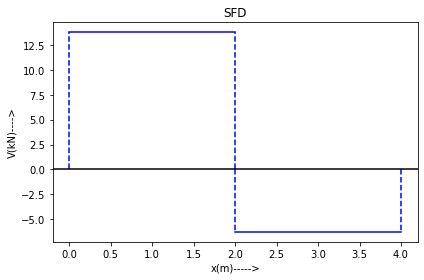

[-15.]
[12.5]


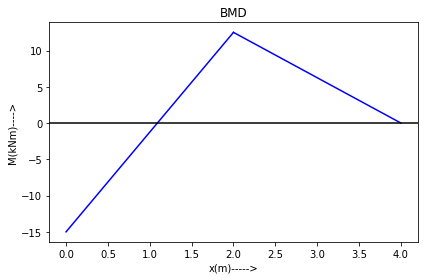

In [5]:
import matplotlib.pyplot as plt
#Plot SFD
N=len(Elem.keys())
fig,ax=plt.subplots(1,1)
for i in Elem.keys():
    member :Beam_element=Elem[i]
    member.plot_SFD(ax)
ax.set_title("SFD")
ax.set_xlabel("x(m)----->")
ax.set_ylabel("V(kN)---->")
plt.tight_layout()
plt.axhline(0, color='black')
plt.show()
#Plot BMD
fig,ax=plt.subplots(1,1)
for i in Elem.keys():
    member :Beam_element=Elem[i]
    member.plot_BMD(ax)
ax.set_title("BMD")
ax.set_xlabel("x(m)----->")
ax.set_ylabel("M(kNm)---->")
plt.axhline(0, color='black')
plt.tight_layout()
plt.show()